In [35]:
import numpy as np
import torch
import cv2
import os
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

In [36]:
import cv2
import json
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils
import random
class COCODataLoader:
    def __init__(self, json_path, image_dir=None, disable_prints=True):
        """
        初始化COCO数据加载器
        Args:
            json_path: COCO json文件的路径
            image_dir: 图片目录的路径，如果为None则默认使用与json同级的images目录
            disable_prints: 是否禁用COCO加载时的打印输出
        """
        self.json_path = json_path
        if image_dir is None:
            self.image_dir = os.path.join(os.path.dirname(json_path), '..', 'images')
        else:
            self.image_dir = image_dir

        self.coco = COCO(json_path)

        # 获取人物类别的图片ID
        self.person_cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_ids = self.coco.getImgIds(catIds=self.person_cat_ids)
        
        print(f"Loaded {len(self.img_ids)} images containing people")

    def get_random_image(self):
        """随机获取一张包含人的图片信息"""
        img_id = random.choice(self.img_ids)
        return self.coco.loadImgs(img_id)[0]

    def load_image_and_mask(self, img_info):
        """加载图片和对应的人物掩码"""
        # 加载图片
        img_path = os.path.join(self.image_dir, img_info['file_name'])
        img = cv2.imread(img_path)[..., ::-1]  # BGR to RGB
        if img is None:
            raise ValueError(f"Failed to load image: {img_path}")
        img = img.astype(np.float32) / 255.0
        
        # 获取该图片中的所有人物标注
        ann_ids = self.coco.getAnnIds(imgIds=img_info['id'], catIds=self.person_cat_ids, iscrowd=False)
        anns = self.coco.loadAnns(ann_ids)
        
        # 创建实例掩码图
        h, w = img_info['height'], img_info['width']
        instance_mask = np.zeros((h, w), dtype=np.uint8)
        
        for i, ann in enumerate(anns, start=1):
            if 'segmentation' in ann:
                if isinstance(ann['segmentation'], dict):  # RLE format
                    rle = ann['segmentation']
                else:  # polygon format
                    rle = maskUtils.frPyObjects(ann['segmentation'], h, w)
                    if len(rle) > 1:
                        rle = maskUtils.merge(rle)
                binary_mask = maskUtils.decode(rle)
                if len(binary_mask.shape) > 2:
                    binary_mask = binary_mask[:,:,0]
                instance_mask[binary_mask > 0] = i
        
        return img.copy(), instance_mask

    def read_single(self):
        """读取单个样本"""
        max_attempts = 10
        for _ in range(max_attempts):
            # 随机选择图片
            img_info = self.get_random_image()
            
            # 加载图片和掩码
            try:
                Img, ann_map = self.load_image_and_mask(img_info)
            except Exception as e:
                print(f"Error loading image: {e}")
                continue

            # 调整大小到1024x1024
            Img = cv2.resize(Img, (1024, 1024))
            ann_map = cv2.resize(ann_map, (1024, 1024), interpolation=cv2.INTER_NEAREST)
            
            # 获取唯一的实例ID（排除背景0）
            inds = np.unique(ann_map)[1:]
            if len(inds) == 0:
                continue
            
            # 随机选择一个实例
            ind = random.choice(inds)
            
            # 创建二值掩码
            mask = (ann_map == ind).astype(np.uint8)
            
            # 获取掩码内的所有坐标点
            coords = np.argwhere(mask > 0)
            if len(coords) == 0:
                continue
            
            # 随机选择一个点
            yx = coords[np.random.randint(len(coords))]
            return Img, mask, [[yx[1], yx[0]]]

        raise RuntimeError("Failed to find valid sample after maximum attempts")

    def read_batch(self, batch_size=10):
        """读取批量样本"""
        limage = []
        lmask = []
        linput_point = []
        
        while len(limage) < batch_size:
            try:
                image, mask, input_point = self.read_single()
                limage.append(image)
                lmask.append(mask)
                linput_point.append(input_point)
            except Exception as e:
                print(f"Error reading sample: {e}")
                continue
        
        return limage, np.array(lmask), np.array(linput_point), np.ones([batch_size, 1])


In [37]:
# loader = COCODataLoader(
#     json_path='/data3/zly/samacoco/samacocoperson/labels_clean_5_percent.json',
#     image_dir='/data3/zly/samacoco/samacocoperson/data',  
#     disable_prints=True  # 可选
# )
loader = COCODataLoader(
    json_path='/data3/zly/crowdhuman/selected_filter_auto_mask_cw_train_split_with_nonperson_mask_clean_5_percent.json',
    image_dir='/data3/zly/crowdhuman/Images',  
    disable_prints=True  # 可选
)

loading annotations into memory...
Done (t=0.20s)
creating index...
index created!
Loaded 750 images containing people


In [38]:
loader.read_batch(1)

([array([[[0.04721201, 0.0981924 , 0.02760417],
          [0.09874387, 0.14972427, 0.07913603],
          [0.13047282, 0.18929635, 0.11478654],
          ...,
          [0.283909  , 0.2672246 , 0.18519574],
          [0.28363422, 0.2639038 , 0.17164116],
          [0.2065164 , 0.21949917, 0.11462786]],
  
         [[0.0268076 , 0.077788  , 0.01032763],
          [0.07990196, 0.13088237, 0.06130515],
          [0.1392626 , 0.19606408, 0.1225653 ],
          ...,
          [0.2937407 , 0.27342004, 0.18686165],
          [0.314709  , 0.285353  , 0.20292777],
          [0.23221652, 0.2287155 , 0.14172244]],
  
         [[0.00854133, 0.05952173, 0.00106584],
          [0.04770532, 0.09868571, 0.03201905],
          [0.12053198, 0.17151238, 0.10092415],
          ...,
          [0.2964322 , 0.2666272 , 0.16689956],
          [0.30487755, 0.26219675, 0.18864794],
          [0.27686074, 0.24391922, 0.18417658]],
  
         ...,
  
         [[0.16936275, 0.18673408, 0.14333402],
          [0.1

In [39]:
sam2_checkpoint = "/data3/zly/multi_ob/segment-anything-2/checkpoints/sam2.1_hiera_small.pt"# 模型权重路径
model_cfg = "./configs/sam2.1/sam2.1_hiera_s.yaml"# 模型配置
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda") # 加载模型
predictor = SAM2ImagePredictor(sam2_model) # 加载网络

In [40]:
# predictor.model.sam_mask_decoder.train(True) # 启用掩码解码器的训练
# predictor.model.sam_prompt_encoder.train(True) # 启用提示编码器的训练
# predictor.model.image_encoder.train(True) # 启用图像编码器的训练
predictor.model.train(True) # 启用整个模型的训练

def set_param_grad(model_dict):
    """
    Set requires_grad=True for all parameters in the given model components
    
    Args:
        model_dict: Dictionary mapping component names to model modules
    """
    grad_count = 0
    for name, component in model_dict.items():
        for param in component.parameters():
            param.requires_grad = True
            grad_count += 1
        print(f"Enabled gradients for {grad_count} parameters in {name}")
        grad_count = 0

# Usage example for your SAM components
model_components = {
    "mask_decoder": predictor.model.sam_mask_decoder,
    "prompt_encoder": predictor.model.sam_prompt_encoder,
    "image_encoder": predictor.model.image_encoder
}

set_param_grad(model_components)


Enabled gradients for 137 parameters in mask_decoder
Enabled gradients for 16 parameters in prompt_encoder
Enabled gradients for 210 parameters in image_encoder


In [41]:
optimizer=torch.optim.AdamW(params=predictor.model.parameters(),lr=1e-4,weight_decay=4e-5)

In [42]:
scaler=torch.cuda.amp.GradScaler() # 设置混合精度

In [43]:
from matplotlib.colors import ListedColormap
import torch.nn.functional as F
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
def display_image_and_mask(image, mask, predicted_mask):
    """显示原始图像、真实掩码和预测掩码"""
    # image_np = image.transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    image_np = image
    mask_np = mask.cpu().detach().numpy()
    prd_mask_np = predicted_mask
    
    n, w, h = mask_np.shape
    label = np.zeros((w, h), dtype=np.int32)
    for i in range(n):
        current_mask = mask_np[i]
        
        label = np.where((current_mask == 1) & (label == 0), i + 1, label)
    
    
    n1, r1, w1, h1 = prd_mask_np.shape
    pre_label = []
    for rank in range(r1):
        prd_mask_np1 = prd_mask_np.cpu().detach().numpy()
        label1 = np.zeros((w1, h1), dtype=np.int32)
        for i in range(n1):
            current_mask = prd_mask_np1[i, rank]
            label1 = np.where((current_mask > 0.5) & (label1 == 0), i + 1, label1)
        pre_label.append(label1.copy())
            
    num_classes = int(label.max() + 1)  
    cmap = plt.get_cmap('tab20', num_classes) 
    norm = mcolors.BoundaryNorm(boundaries=np.arange(num_classes + 1) - 0.5, ncolors=num_classes)
    
    num_classes2 = int(pre_label[0].max() + 1)  
    cmap2 = plt.get_cmap('tab20', num_classes2)  
    norm2 = mcolors.BoundaryNorm(boundaries=np.arange(num_classes2 + 1) - 0.5, ncolors=num_classes2)
    
    num_classes3 = int(pre_label[1].max() + 1)  
    cmap3 = plt.get_cmap('tab20', num_classes3) 
    norm3 = mcolors.BoundaryNorm(boundaries=np.arange(num_classes3 + 1) - 0.5, ncolors=num_classes3)
    
    num_classes4 = int(pre_label[2].max() + 1)  
    cmap4 = plt.get_cmap('tab20', num_classes4)  
    norm4 = mcolors.BoundaryNorm(boundaries=np.arange(num_classes4 + 1) - 0.5, ncolors=num_classes4)

    # Plotting
    fig, ax = plt.subplots(1, 5, figsize=(15, 5))
    # print(f"Image shape before transposition: {image_np.shape}")
    ax[0].imshow(image_np)
    ax[0].set_title("Original Image")
    ax[0].axis('off')

    ax[1].imshow(label, cmap=cmap, norm=norm)
    ax[1].set_title("Original Mask")
    ax[1].axis('off')
    
    ax[2].imshow(pre_label[0], cmap=cmap2, norm=norm2)
    ax[2].set_title("Predicted Mask1")
    ax[2].axis('off')
    
    ax[3].imshow(pre_label[1], cmap=cmap3, norm=norm3)
    ax[3].set_title("Predicted Mask2")
    ax[3].axis('off')
    
    ax[4].imshow(pre_label[2], cmap=cmap4, norm=norm4)
    ax[4].set_title("Predicted Mask2")
    ax[4].axis('off')

    ax[0].set_aspect('auto')  

    plt.show()


In [44]:
def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True, stability_score = 0.0):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        
        plt.title(f"Mask {i+1}, pred iou: {score:.3f}, stability_score: {stability_score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

In [45]:
# model_state_dict = torch.load("model_coco.torch")
# predictor.model.load_state_dict(model_state_dict)

In [46]:
# from PIL import Image
# img_path = '/data3/zly/crowdhuman/Images/273275,14c13e0004f76a23a.jpg'
# image = Image.open(img_path)
# input_point = np.array([[320.0,400.0]])
# input_label = np.array([1])


In [47]:
# from matplotlib import pyplot as plt
# plt.figure(figsize=(10, 10))
# plt.imshow(image)
# show_points(input_point, input_label, plt.gca())
# plt.axis('on')
# plt.show()  

In [48]:
# from sam2.utils.amg import calculate_stability_score
# predictor.set_image(image)
# with torch.no_grad():
#     logits_masks, scores, logits = predictor.predict(
#         point_coords=input_point,
#         point_labels=input_label,
#         multimask_output=True,
#         return_logits=True,
#     )
#     stability_score = calculate_stability_score(torch.tensor(logits_masks), predictor._transforms.mask_threshold, 1.0)  
#     masks = logits_masks > 0.0
#     sorted_ind = np.argsort(scores)[::-1]
#     masks = masks[sorted_ind]
#     scores = scores[sorted_ind]
#     logits = logits[sorted_ind]

In [49]:
# show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label, borders=True,stability_score=0.9)

In [50]:
from PIL import Image, ImageDraw
import torchvision.transforms as T
class VisualizationHelper:
    def __init__(self, save_dir='./runs/vis'):
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)
        
    def draw_points(self, image, points, labels):
        """Draw click points on the image"""
        draw = ImageDraw.Draw(image)
        if isinstance(points, torch.Tensor):
            points = points.cpu().numpy()
        if isinstance(labels, torch.Tensor):
            labels = labels.cpu().numpy()
        
        for pt, label in zip(points, labels):
            x, y = pt[0], pt[1]
            color = 'green' if label > 0 else 'red'
            
            if label > 0:
                radius = 5
                draw.ellipse((x-radius, y-radius, x+radius, y+radius), 
                            fill=color, outline='white')
            else:
                size = 5
                draw.line((x-size, y-size, x+size, y+size), 
                         fill=color, width=2)
                draw.line((x-size, y+size, x+size, y-size), 
                         fill=color, width=2)
        return image
    
    def blend_mask(self, image, mask, color=(255, 0, 0, 128)):
        """Blend mask with image"""
        if isinstance(mask, torch.Tensor):
            mask = mask.cpu().numpy()
        mask_img = Image.fromarray((mask * 255).astype(np.uint8))
        mask_img = mask_img.convert('L')
        overlay = Image.new('RGBA', image.size, color)
        mask_img = mask_img.resize(image.size, Image.BILINEAR)
        image.paste(overlay, mask=mask_img)
        return image

    def convert_to_pil(self, image):
        """Convert various image formats to PIL Image"""
        if isinstance(image, np.ndarray):
            # 如果是numpy数组，假设是RGB格式，值范围0-1
            image = (image * 255).astype(np.uint8)
            return Image.fromarray(image)
        elif isinstance(image, torch.Tensor):
            if image.is_cuda:
                image = image.cpu()
            # 取消归一化
            denorm = T.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                               std=[1/0.229, 1/0.224, 1/0.225])
            image = denorm(image).clamp(0, 1)
            return T.ToPILImage()(image)
        elif isinstance(image, Image.Image):
            return image
        else:
            raise TypeError(f"Unsupported image type: {type(image)}")
    
    def save_visualizations(self, images, pred_masks, gt_masks, points, labels, iteration):
        # 获取batch大小
        batch_size = len(images)
        
        # 为每个batch创建子目录
        batch_dir = os.path.join(self.save_dir, f'iter_{iteration}')
        os.makedirs(batch_dir, exist_ok=True)
        
        # 遍历batch中的每个样本
        for idx in range(batch_size):
            # 转换当前样本的图像为PIL格式
            image_pil = self.convert_to_pil(images[idx])
            
            # 确保mask是正确的格式
            if isinstance(pred_masks, torch.Tensor):
                pred_mask = pred_masks[idx].cpu().numpy()
            else:
                pred_mask = pred_masks[idx]
                
            if isinstance(gt_masks, torch.Tensor):
                gt_mask = gt_masks[idx].cpu().numpy()
            else:
                gt_mask = gt_masks[idx]
            
            # 1. Image + predicted mask + points
            pred_vis = image_pil.copy().convert('RGBA')
            pred_vis = self.blend_mask(pred_vis, pred_mask > 0.5)
            pred_vis = self.draw_points(pred_vis, points[idx], labels[idx])
            pred_vis.save(os.path.join(batch_dir, f'sample_{idx}_pred.png'))
            
            # 2. Image + ground truth mask
            gt_vis = image_pil.copy().convert('RGBA')
            gt_vis = self.blend_mask(gt_vis, gt_mask, color=(0, 255, 0, 128))
            gt_vis.save(os.path.join(batch_dir, f'sample_{idx}_gt.png'))
            
            # 3. Original image
            image_pil.save(os.path.join(batch_dir, f'sample_{idx}_image.png'))

In [51]:
visualizer = VisualizationHelper()

In [52]:
import datetime
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.tensorboard import SummaryWriter

current_time_str = datetime.datetime.now().strftime("%Y%m%d-%H%M")
writer = SummaryWriter(log_dir=f'runs/COCO/{current_time_str}') 

mean_iou_list = []
for itr in range(3000):
    with torch.cuda.amp.autocast():  
        image, mask, input_point, input_label = loader.read_batch(16)  
        if mask.shape[0] == 0:
            continue  
        predictor.set_image_batch(image) 
        
        mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(input_point, input_label, box=None, mask_logits=None, normalize_coords=True)
        sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(points=(unnorm_coords, labels), boxes=None, masks=None)
        # high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
        high_res_features = predictor._features["high_res_feats"]
        low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
            image_embeddings=predictor._features["image_embed"],
            image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=True,
            repeat_image=False,
            high_res_features=high_res_features,)

        prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])  # Upscale the masks to the original image resolution

        gt_mask = torch.tensor(mask.astype(np.float32)).cuda()
        prd_mask = torch.sigmoid(prd_masks[:, 0])  # Turn logit map to probability map

        seg_loss = (-gt_mask * torch.log(prd_mask + 0.00001) - (1 - gt_mask) * torch.log((1 - prd_mask) + 0.00001)).mean()  # cross entropy loss

        inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
        iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)
        score_loss = torch.abs(prd_scores[:, 0] - iou).mean()
        loss = seg_loss + score_loss * 0.25  # mix losses

        predictor.model.zero_grad()  # empty gradient
        scaler.scale(loss).backward()  # Backpropagate
        scaler.step(optimizer)
        scaler.update()  # Mix precision

        if itr % 100 == 99:
            torch.save(predictor.model.state_dict(), "model_coco.torch")
            print("save model")

        mean_iou = np.mean(iou.cpu().detach().numpy())
        mean_iou_list.append(mean_iou)

        if itr % 20 == 19: 
            print("step)", itr, "Accuracy(IOU)=", sum(mean_iou_list) / len(mean_iou_list))
        writer.add_scalar('Loss', loss, itr)
        writer.add_scalar('mean_iou', mean_iou, itr)
        
        if itr % 30 == 9:
            visualizer.save_visualizations(
                image,
                prd_mask.detach(),
                gt_mask.detach(),
                input_point,
                input_label,
                itr
            )

writer.close()

step) 19 Accuracy(IOU)= 0.6511233761906624
step) 39 Accuracy(IOU)= 0.6508397869765759
step) 59 Accuracy(IOU)= 0.6597684954603513
step) 79 Accuracy(IOU)= 0.6704626556485891
save model
step) 99 Accuracy(IOU)= 0.6786403968930245
step) 119 Accuracy(IOU)= 0.6807757380108038
step) 139 Accuracy(IOU)= 0.6820211289184434
step) 159 Accuracy(IOU)= 0.6800017124041915
step) 179 Accuracy(IOU)= 0.6761059395141071
save model
step) 199 Accuracy(IOU)= 0.678250248581171
step) 219 Accuracy(IOU)= 0.6803503555330364
step) 239 Accuracy(IOU)= 0.6786091229567925
step) 259 Accuracy(IOU)= 0.6763661553080266
step) 279 Accuracy(IOU)= 0.6767068596822875
save model
step) 299 Accuracy(IOU)= 0.6733747488260269
step) 319 Accuracy(IOU)= 0.6733278002589941
step) 339 Accuracy(IOU)= 0.6725370985620162
step) 359 Accuracy(IOU)= 0.6740185972717073
step) 379 Accuracy(IOU)= 0.6726078108737343
save model
step) 399 Accuracy(IOU)= 0.6722695660591126
step) 419 Accuracy(IOU)= 0.6728682603154864
step) 439 Accuracy(IOU)= 0.67530482587

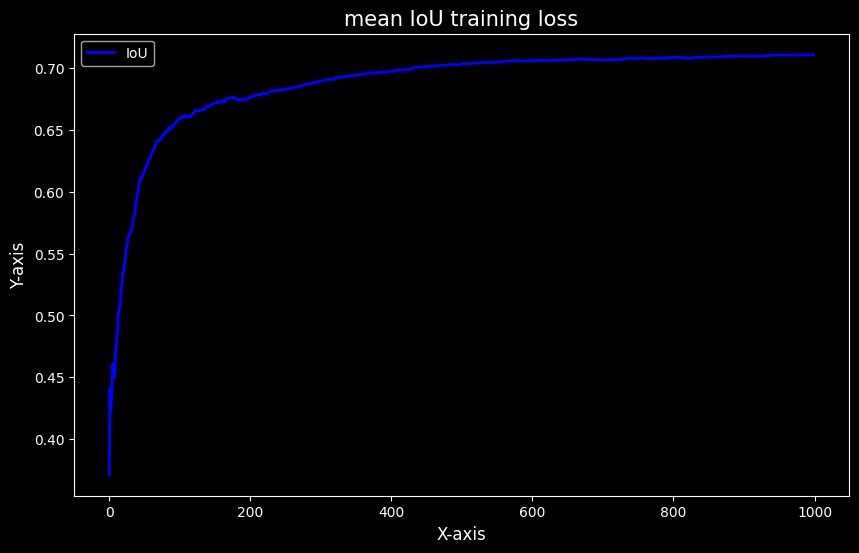

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

cumulative_mean_iou = [np.mean(mean_iou_list[:i+1]) for i in range(len(mean_iou_list))]

x = range(len(mean_iou_list))
y1 = cumulative_mean_iou

plt.figure(figsize=(10, 6))
plt.plot(x, y1, label="IoU", color="b", linewidth=2)

plt.title("mean IoU training loss", fontsize=15)
plt.xlabel("X-axis", fontsize=12)
plt.ylabel("Y-axis", fontsize=12)
plt.legend()
plt.show()